In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np
import sys
import astropy.units as u
from astropy.io import ascii, fits
from astropy.modeling.blackbody import blackbody_lambda
sys.path.insert(0, '../')
from libra import Spot, Star, IRTFTemplate

In [134]:
f = fits.open('../libra/data/trappist1/spex_sxd-merge_2306-0502_151118.fits')

wavelength = f[0].data[0, :] * u.um
flux = f[0].data[1, :] * u.erg * u.s**-1 * u.cm**-2 * u.Angstrom**-1
flux = flux.to(u.W * u.m**-2 * u.um**-1)
flux[(flux < 0) | np.isnan(flux) | (flux.value > 1.5e-13)] = 0

 ############################## Xspextool History ############################## [astropy.io.fits.card]
 ############################## Xcombspec History ############################## [astropy.io.fits.card]
 ############################### Xtellcor History ############################## [astropy.io.fits.card]
 ############################# Xmergeorders History ############################ [astropy.io.fits.card]
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy-3.0.dev19880-py3.5-macosx-10.6-x86_64.egg/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in less
  *arrays, **kwargs)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater


In [135]:
from synphot import units, SourceSpectrum, Empirical1D, Observation

from synphot import SpectralElement

v = SourceSpectrum.from_vega()

bp_i = SpectralElement.from_filter('cousins_i')
bp_j = SpectralElement.from_file('/Users/bmmorris/git/libra/libra/data/filters/2MASS_2MASS.J.dat.txt')

sp = SourceSpectrum(Empirical1D, points=wavelength.to(u.Angstrom), lookup_table=flux)

force = 'taper'
obs_i = Observation(sp, bp_i, force=force)
obs_j = Observation(sp, bp_j, force=force)

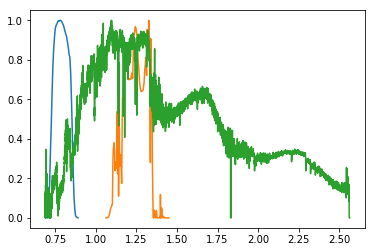

In [136]:
tmp = bp_i.model
plt.plot(tmp.points[0]/10000, tmp.lookup_table)
tmp = bp_j.model
plt.plot(tmp.points[0]/10000, tmp.lookup_table)
plt.plot(wavelength, flux/flux.max())

In [137]:
from glob import glob

paths = glob('/Users/bmmorris/git/freckles/data/lte*BT-Settl.spec.fits')

from astropy.io import fits

phoenix_wavelengths = fits.getdata(paths[0])['Wavelength']

temperatures = []
model_fluxes = []

for path in paths:
    hdu = fits.open(path)
    temperatures.append(hdu[1].header['PHXTEFF'])
    interp_flux = np.interp(phoenix_wavelengths, hdu[1].data['Wavelength'], hdu[1].data['Flux'])
    model_fluxes.append(interp_flux)
    
model_fluxes = np.vstack(model_fluxes)
temperatures = np.array(temperatures)

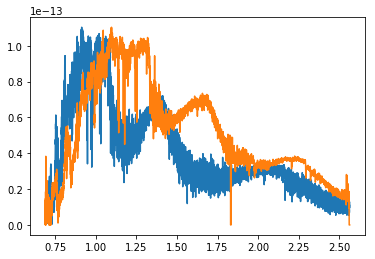

In [138]:
closest_model = model_fluxes[np.argmin(np.abs(temperatures - 2500))]

bin_width = np.median(np.diff(wavelength))
wavelength_bins = np.linspace(wavelength.min()-bin_width/2, wavelength.max()+bin_width/2, len(wavelength) + 1)

from scipy.stats import binned_statistic

bs = binned_statistic(phoenix_wavelengths, closest_model, bins=wavelength_bins.value, statistic='mean')
binned_phoenix = bs.statistic
binned_phoenix[np.isnan(binned_phoenix)] = 0

scale_factor = flux.max() / binned_phoenix.max()
plt.plot(wavelength, binned_phoenix * scale_factor)
plt.plot(wavelength, flux)

In [163]:
spotted_areas = np.logspace(-4, -1, 10)
# spotted_areas = [0.00001, 0.1]
spot_temperatures = temperatures[(temperatures <= 7000) & (temperatures >= 2500)]
# spot_temperatures = [2700, 4000]

In [164]:
from synphot import units, SourceSpectrum, Empirical1D, Observation

from synphot import SpectralElement

v = SourceSpectrum.from_vega()

bp_i = SpectralElement.from_filter('cousins_i')
bp_j = SpectralElement.from_file('/Users/bmmorris/git/libra/libra/data/filters/2MASS_2MASS.J.dat.txt')
sp = SourceSpectrum(Empirical1D, points=wavelength.to(u.Angstrom), lookup_table=flux)
trappist_1_i_minus_j = obs_i.effstim('vegamag', vegaspec=v) - obs_j.effstim('vegamag', vegaspec=v)
print(trappist_1_i_minus_j)

2.803943981471841 VEGAMAG


I = 14.0, J = 11.4,

Answer should be I-J = 2.6

In [165]:
from astropy.utils.console import ProgressBar

i_minus_j = np.zeros((len(spotted_areas), len(spot_temperatures)))

with ProgressBar(len(spotted_areas) * len(spot_temperatures), ipython_widget=True) as bar:
    for i, area in enumerate(spotted_areas): 
        for j, temp in enumerate(spot_temperatures): 
            hot_spot_flux = model_fluxes[np.argmin(np.abs(temperatures - temp)), :]
            bs = binned_statistic(phoenix_wavelengths, hot_spot_flux, bins=wavelength_bins.value, statistic='mean')
            binned_phoenix = bs.statistic
            binned_phoenix[np.isnan(binned_phoenix)] = 0
            binned_phoenix *= scale_factor.value
            
            total_flux = binned_phoenix * area + (1 - area) * flux.value

            sp = SourceSpectrum(Empirical1D, points=wavelength.to(u.Angstrom), lookup_table=total_flux * flux.unit)
            force = 'taper'
            obs_i = Observation(sp, bp_i, force=force)
            obs_j = Observation(sp, bp_j, force=force)
            
            grid_vegamag = obs_i.effstim('vegamag', vegaspec=v) - obs_j.effstim('vegamag', vegaspec=v)

            i_minus_j[i, j] = grid_vegamag.value
            
            bar.update()
#             plt.plot(wavelength, flux)
#             plt.plot(wavelength, total_flux, ls='--')
#             plt.show()

2.803943981471841 VEGAMAG


/Users/bmmorris/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:1376: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  'yscale=%s' % (xscale, yscale))


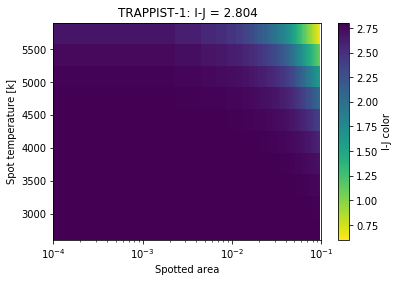

In [166]:
img = plt.imshow(i_minus_j, extent=extent, aspect=1e-5, origin='lower', vmax=trappist_1_i_minus_j.value, 
                 cmap=plt.cm.viridis_r)
print(trappist_1_i_minus_j)
plt.title("TRAPPIST-1: I-J = {0:.3f}".format(trappist_1_i_minus_j.value))
plt.colorbar(img, label='I-J color')
plt.xscale('log')
plt.xlabel('Spotted area')
plt.ylabel('Spot temperature [k]')
plt.savefig('color_error.pdf', bbox_inches='tight')

In [168]:
i_minus_j.shape, spotted_areas.shape, spot_temperatures.shape

((10, 46), (10,), (46,))

In [167]:
np.savez('color_grid.npz', i_minus_j, spotted_areas, spot_temperatures)

In [25]:
from scipy.interpolate import interp2d

In [26]:
f = interp2d(spot_temperatures, spotted_areas, fractional_err)

In [27]:
f(3500, 0.001)

array([ 0.00969642])